In [11]:
import fastai; fastai.__version__
from fastai.vision import *
from fastai.callbacks import *

In [2]:
torch.cuda.set_device(7)

In [3]:
import sys; sys.path.append("../dev")

In [105]:
from local.segmentation.dataset import SemanticSegmentationData
from local.segmentation.metrics import *
# test data creation
PATH = Path("/home/turgutluk/data/siim_acr_pneu/")
IMAGES, MASKS, CODES, TRAIN, VALID, TEST = \
    "train/images_1024", "train/masks_1024", "codes.txt", "train.txt", 0.1, "test.txt"
ssdata = SemanticSegmentationData(PATH, IMAGES, MASKS, CODES, TRAIN, VALID, TEST, 
                                  sample_size=1000, bs=1, size=768)
data = ssdata.get_data()

In [106]:
PATH.ls()

[PosixPath('/home/turgutluk/data/siim_acr_pneu/tmp'),
 PosixPath('/home/turgutluk/data/siim_acr_pneu/preds'),
 PosixPath('/home/turgutluk/data/siim_acr_pneu/train'),
 PosixPath('/home/turgutluk/data/siim_acr_pneu/clas_df.csv'),
 PosixPath('/home/turgutluk/data/siim_acr_pneu/test.txt'),
 PosixPath('/home/turgutluk/data/siim_acr_pneu/dicom-images-test'),
 PosixPath('/home/turgutluk/data/siim_acr_pneu/models'),
 PosixPath('/home/turgutluk/data/siim_acr_pneu/dicom-images-train'),
 PosixPath('/home/turgutluk/data/siim_acr_pneu/train-rle.csv'),
 PosixPath('/home/turgutluk/data/siim_acr_pneu/train.txt'),
 PosixPath('/home/turgutluk/data/siim_acr_pneu/codes.txt'),
 PosixPath('/home/turgutluk/data/siim_acr_pneu/test_2'),
 PosixPath('/home/turgutluk/data/siim_acr_pneu/stage_2_images.zip'),
 PosixPath('/home/turgutluk/data/siim_acr_pneu/seg_df.csv'),
 PosixPath('/home/turgutluk/data/siim_acr_pneu/learn'),
 PosixPath('/home/turgutluk/data/siim_acr_pneu/test')]

In [107]:
rle_df = pd.read_csv(PATH/'train-rle.csv')
yes_pneumo = rle_df.loc[rle_df[' EncodedPixels'] != " -1", 'ImageId'].values
yes_pneumo = [f"{Path(o)}.png" for o in yes_pneumo]

In [115]:
from torch.utils.data.sampler import *

class OverSamplingCallback(LearnerCallback):
    def __init__(self,learn:Learner,binary_lbl_fns:list=None,weights:torch.Tensor=None):
        "binary_lbl_fns has list of image filenames with at least 1 non-background pixel"
        super().__init__(learn)
        self.weights = weights
        self.binary_lbl_fns = binary_lbl_fns

    def on_train_begin(self, **kwargs):
        self._labels = self.learn.data.train_dl.dataset.y.items
        if self.binary_lbl_fns: self.labels = [1 if o.name in self.binary_lbl_fns else 0 for o in self._labels]
        else: self.labels = self._labels
        
        _, counts = np.unique(self.labels,return_counts=True)
        if self.weights is None: self.weights = (1/counts)[self.labels]
        else: self.weights = self.weights[self.labels] 
#         self.label_counts = np.bincount([self.learn.data.train_dl.dataset.y[i].data for i in range(len(self.learn.data.train_dl.dataset))])
#         self.total_len_oversample = int(self.learn.data.c*np.max(self.label_counts))
        self.total_len_oversample = len(self._labels)
        self.learn.data.train_dl.dl.batch_sampler = BatchSampler(WeightedRandomSampler(self.weights,self.total_len_oversample), self.learn.data.train_dl.batch_size,False)

In [109]:
learn = unet_learner(data, models.resnet34);
learn.metrics = [dice]
learn.path = Path(".")
learn.to_fp16();

In [110]:
learn.callback_fns.append(partial(OverSamplingCallback, binary_lbl_fns=yes_pneumo, weights=tensor([0.8, 0.2])))

In [ ]:
learn.fit_one_cycle(2, 1e-3)

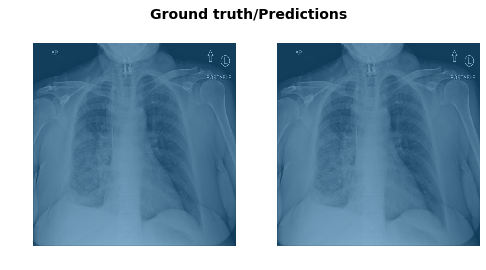

In [125]:
learn.show_results(rows=3)

In [84]:
res = learn.get_preds(DatasetType.Valid)

In [85]:
preds, targs = res

In [86]:
preds.shape, targs.shape

(torch.Size([10, 2, 768, 768]), torch.Size([10, 1, 768, 768]))

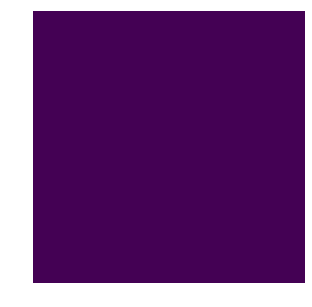

In [103]:
ImageSegment(preds.argmax(1)[9][None,...]).show(figsize=(5,5), cmap='viridis', alpha=1)